In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [5]:
from collections import defaultdict, Counter

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
import re
import torch
from typing import Union, Callable
from tqdm.auto import tqdm

from src.utils import concat_csv_with_indices

In [8]:
sns.set_context("talk", font_scale=1.5)

In [11]:
recognition_point_df = concat_csv_with_indices(
    "outputs/notebooks/librispeech-train-clean-100/**/word_discrimination/recognition_points.csv",
    [lambda p: p.parents[1].name,
        lambda p: p.parents[2].name, lambda p: p.parents[3].name,
        lambda p: p.parents[4].name],
    ["equivalence", "model", "base_model", "dataset"]).reset_index()

recognition_point_df["trace"] = recognition_point_df.base_model + "/" + recognition_point_df.model + "/" + recognition_point_df.equivalence

In [12]:
recognition_point_df.trace.unique()

array(['w2v2_8/randomrnn_8/random',
       'w2v2_8/rnn_32-hinge_ph-mAP3/phoneme_10frames',
       'w2v2_8/rnn_32-hinge_ph-mAP4/phoneme_10frames',
       'w2v2_8/randomff_32/random',
       'w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames',
       'w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_fixedlen25',
       'w2v2_8/rnn_32-hinge_ph-mAP1/phoneme_10frames',
       'w2v2_8/rnn_8-weightdecay0.01/syllable_10frames',
       'w2v2_8/randomrnn_32/random',
       'w2v2_8/rnn_32-hinge_ph-mAP5/phoneme_10frames',
       'w2v2_8/rnn_32-hinge_ph-mAP2/phoneme_10frames',
       'w2v2_8/randomff_8/random'], dtype=object)

In [16]:
plot_traces = {
    "Word": "w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames",
    "Random": "w2v2_8/randomrnn_32/random",
    "Phoneme": "w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames",
}
recognition_point_df = recognition_point_df[recognition_point_df.trace.isin(plot_traces.values())]
recognition_point_df["Trace"] = recognition_point_df.trace.map({v: k for k, v in plot_traces.items()})

/tmp/ipykernel_1582923/314214369.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recognition_point_df["Trace"] = recognition_point_df.trace.map({v: k for k, v in plot_traces.items()})


/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

<Axes: xlabel='recognized_gt_point', ylabel='Count'>

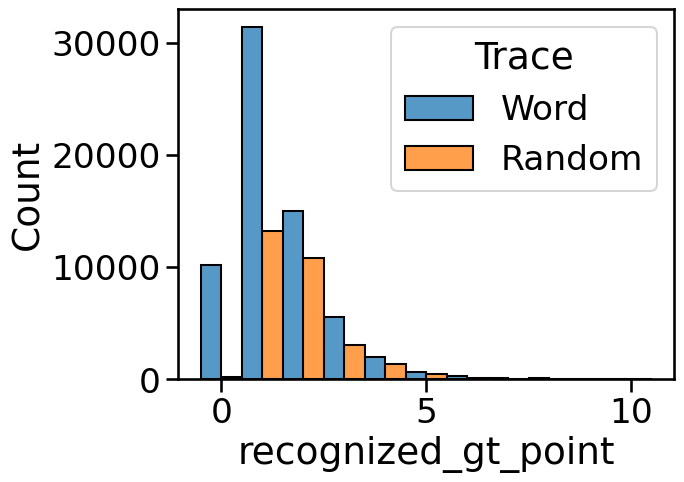

In [10]:
# dodge histogram
sns.histplot(recognition_point_df, x="recognized_gt_point", hue="Trace",
             discrete=True, multiple="dodge")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Recognition point', ylabel='Proportion'>

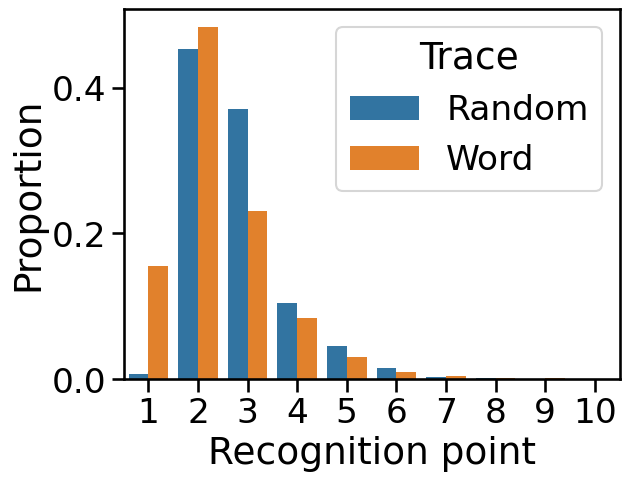

In [54]:
recognition_point_df[(recognition_point_df.recognized_gt_point < 10)].rename(columns={"recognized_gt_point": "Recognition point"}) \
    .dropna() \
    .assign(**{"Recognition point": lambda df: df["Recognition point"].astype(int) + 1}) \
    .groupby(["Trace"])["Recognition point"].value_counts(normalize=True) \
    .rename("Proportion").reset_index() \
    .pipe(lambda df: sns.barplot(data=df, x="Recognition point", y="Proportion", hue="Trace"))

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

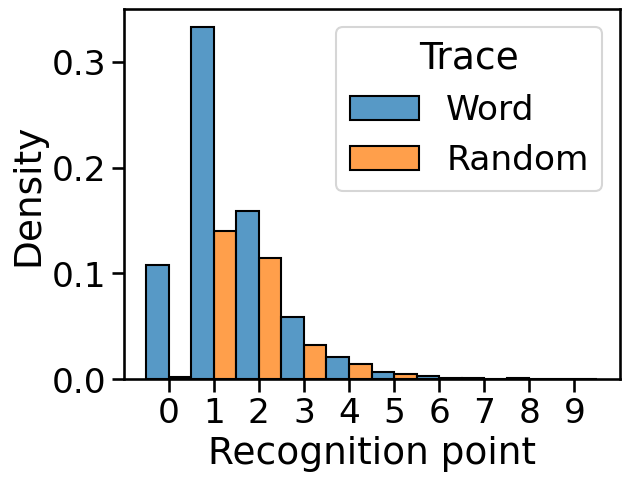

In [38]:
ax = sns.histplot(data=recognition_point_df[(recognition_point_df.recognized_gt_point < 10)].rename(columns={"recognized_gt_point": "Recognition point"}),
                  x="Recognition point", hue="Trace", discrete=True, multiple="dodge", stat="density")
ax.set_xticks(range(0, 10))